In [1]:
import os
import torch
from torchvision import transforms

In [2]:
# change the cwd to the project root
os.chdir("..")

In [3]:
from data.dataloader import cwd_splitter, cwd_loader
root_dir = "/data_hdd1/users/Talha/data/cwd30/dataset/"
train_dict, test_dict = cwd_splitter(root_dir, 0.8)

# train and test loader
# convert to tensor transform
transform = transforms.Compose([transforms.ToTensor()])
train_loader = cwd_loader(train_dict, batch_size=1, shuffle=True, transform=transform)
test_loader = cwd_loader(test_dict, batch_size=1, shuffle=False, transform=transform)

In [4]:
len(train_loader.dataset.key2lbl.keys())

30

torch.Size([1, 3, 512, 512])
torch.Size([1])


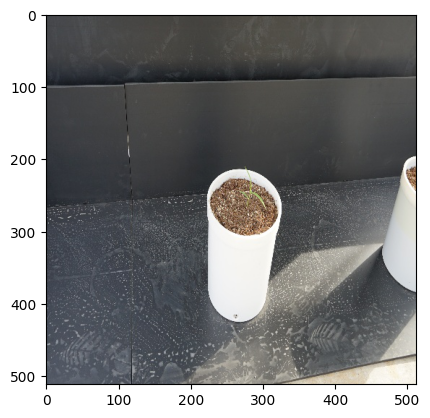

[29]
fall-panicum


In [5]:
# plot an imag and a label from the train loader
import matplotlib.pyplot as plt
import numpy as np

for i, (img, label) in enumerate(train_loader):
    print(img.shape)
    print(label.shape)
    # convert the tensor to numpy array
    img = img.numpy()
    label = label.numpy()
    # change the shape from (1, 3, 512, 512) to (512, 512, 3)
    img = np.transpose(img, (0, 2, 3, 1))
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.show()
    print(label)
    print(train_loader.dataset.lbl2key[label[0]])
    break

In [6]:
import timm

In [7]:
# data loader for iNaturalist
from data.dataloader import inat_loader, inat_files

train_dir = "/data_hdd1/users/Talha/inat2021/"
train_files, val_files, dir_to_label = inat_files(train_dir)

In [8]:
print("Training files: ", len(train_files))
print("Validation files: ", len(val_files))

Training files:  213550
Validation files:  42710


In [9]:
transform = transforms.Compose([transforms.ToTensor()])
train_loader = inat_loader(train_files, dir2lbl=dir_to_label, batch_size=1, shuffle=True, transform=transform)
test_loader = inat_loader(val_files, dir2lbl=dir_to_label, batch_size=1, shuffle=False, transform=transform)

torch.Size([1, 3, 250, 500])
torch.Size([1])


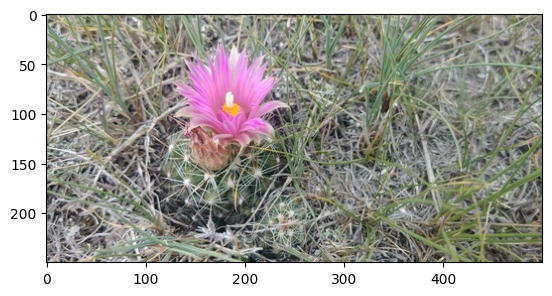

[1646]
07375_Plantae_Tracheophyta_Magnoliopsida_Caryophyllales_Cactaceae_Escobaria_vivipara


In [10]:
# plot an imag and a label from the train loader
import matplotlib.pyplot as plt
import numpy as np

for i, (img, label) in enumerate(train_loader):
    print(img.shape)
    print(label.shape)
    # convert the tensor to numpy array
    img = img.numpy()
    label = label.numpy()
    # change the shape from (1, 3, 512, 512) to (512, 512, 3)
    img = np.transpose(img, (0, 2, 3, 1))
    plt.imshow(np.squeeze(img), cmap='gray')
    plt.show()
    print(label)
    print(train_loader.dataset.lbl2key[label[0]])
    break

In [11]:
len(list(train_loader.dataset.lbl2key.keys()))

4271

In [66]:
checkpoint_path = ""

if checkpoint_path:
    print("Loading checkpoint...")

In [30]:
from timm.models.resnet import default_cfgs

In [42]:
default_cfgs['resnet50'].default.to_dict()

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'hf_hub_id': 'timm/',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'test_input_size': (3, 288, 288),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'test_crop_pct': 1.0,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'origin_url': 'https://github.com/huggingface/pytorch-image-models',
 'paper_ids': 'arXiv:2110.00476'}

In [46]:
# change the url to the local path
default_cfgs['resnet50']['url'] = "/data_hdd1/users/khubaib/CWD30/output/train/20231101-115809-resnet50_a1_in1k-224/checkpoint-29.pth.tar"

TypeError: 'DefaultCfg' object does not support item assignment

In [54]:
ptcfg = timm.models._registry.get_pretrained_cfg(model_name)

In [55]:
ptcfg.pop('url', None)

AttributeError: 'PretrainedCfg' object has no attribute 'pop'

In [32]:
import torch
import timm
from timm import utils

utils.setup_default_logging()


model_name = 'vit_base_patch16_224.augreg2_in21k_ft_in1k'
ptcfg = timm.models._registry.get_pretrained_cfg(model_name)
ptcfg.url = None
pretrained_weights = './output/train/20231108-211157-vit_base_patch16_224_augreg2_in21k_ft_in1k-224/checkpoint-12.pth.tar'
ptcfg.file = pretrained_weights
ptcfg.num_classes = 30


# load timm resnet model with a checkpoint
model = timm.create_model(
    model_name,
    # pretrained=True,
    pretrained_cfg=ptcfg,
    num_classes=4271,
    in_chans=3,
)

# from timm.models import load_checkpoint
# load pretrained weights from checkpoint
checkpoint = torch.load(pretrained_weights, map_location='cpu')
# check if the extension is .pth.tar
if pretrained_weights.endswith('.pth.tar'):
    model.load_state_dict(checkpoint['state_dict'])
else:
    model.load_state_dict(checkpoint['model_state_dict'])

In [12]:
model.head.in_features

768

In [27]:
model = model.to('cuda')

In [16]:
# set the current working directory to the project root
import os
os.chdir("..")
from data.dataloader import cwd_splitter, cwd_loader, CWD_Dataset, CWD_Dataset_Filter

In [17]:
train_dict, test_dict = cwd_splitter("/data_hdd1/users/Talha/data/cwd30/dataset/", 0.8)
dataset_train = CWD_Dataset(train_dict)
dataset_eval = CWD_Dataset(test_dict)

In [22]:
from timm.data import create_loader, resolve_data_config

# create a loader from the dataset
batch_size = 36
num_workers = 4
data_config = resolve_data_config({}, model=model)
loader_train = create_loader(
    dataset_train,
    input_size=data_config['input_size'],
    batch_size=batch_size,
    is_training=True,
    use_prefetcher=True,
    interpolation=data_config['interpolation'],
    mean=None,
    std=None,
    num_workers=num_workers,
    distributed=False,
    pin_memory=True,
)

loader_eval = create_loader(
    dataset_eval,
    input_size=data_config['input_size'],
    batch_size=batch_size,
    is_training=False,
    use_prefetcher=True,
    interpolation=data_config['interpolation'],
    mean=data_config['mean'],
    std=data_config['std'],
    num_workers=num_workers,
    distributed=False,
    pin_memory=True,
)

In [33]:
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.5, 0.5, 0.5),
 'std': (0.5, 0.5, 0.5),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [28]:
# test the model on the test set
import torch
import torch.nn.functional as F
from contextlib import suppress

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for idx, (input, target) in enumerate(loader_eval):
        with suppress():
            output = model(input)
            loss = F.cross_entropy(output, target)

        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
        

Accuracy of the network on the test images: 0 %


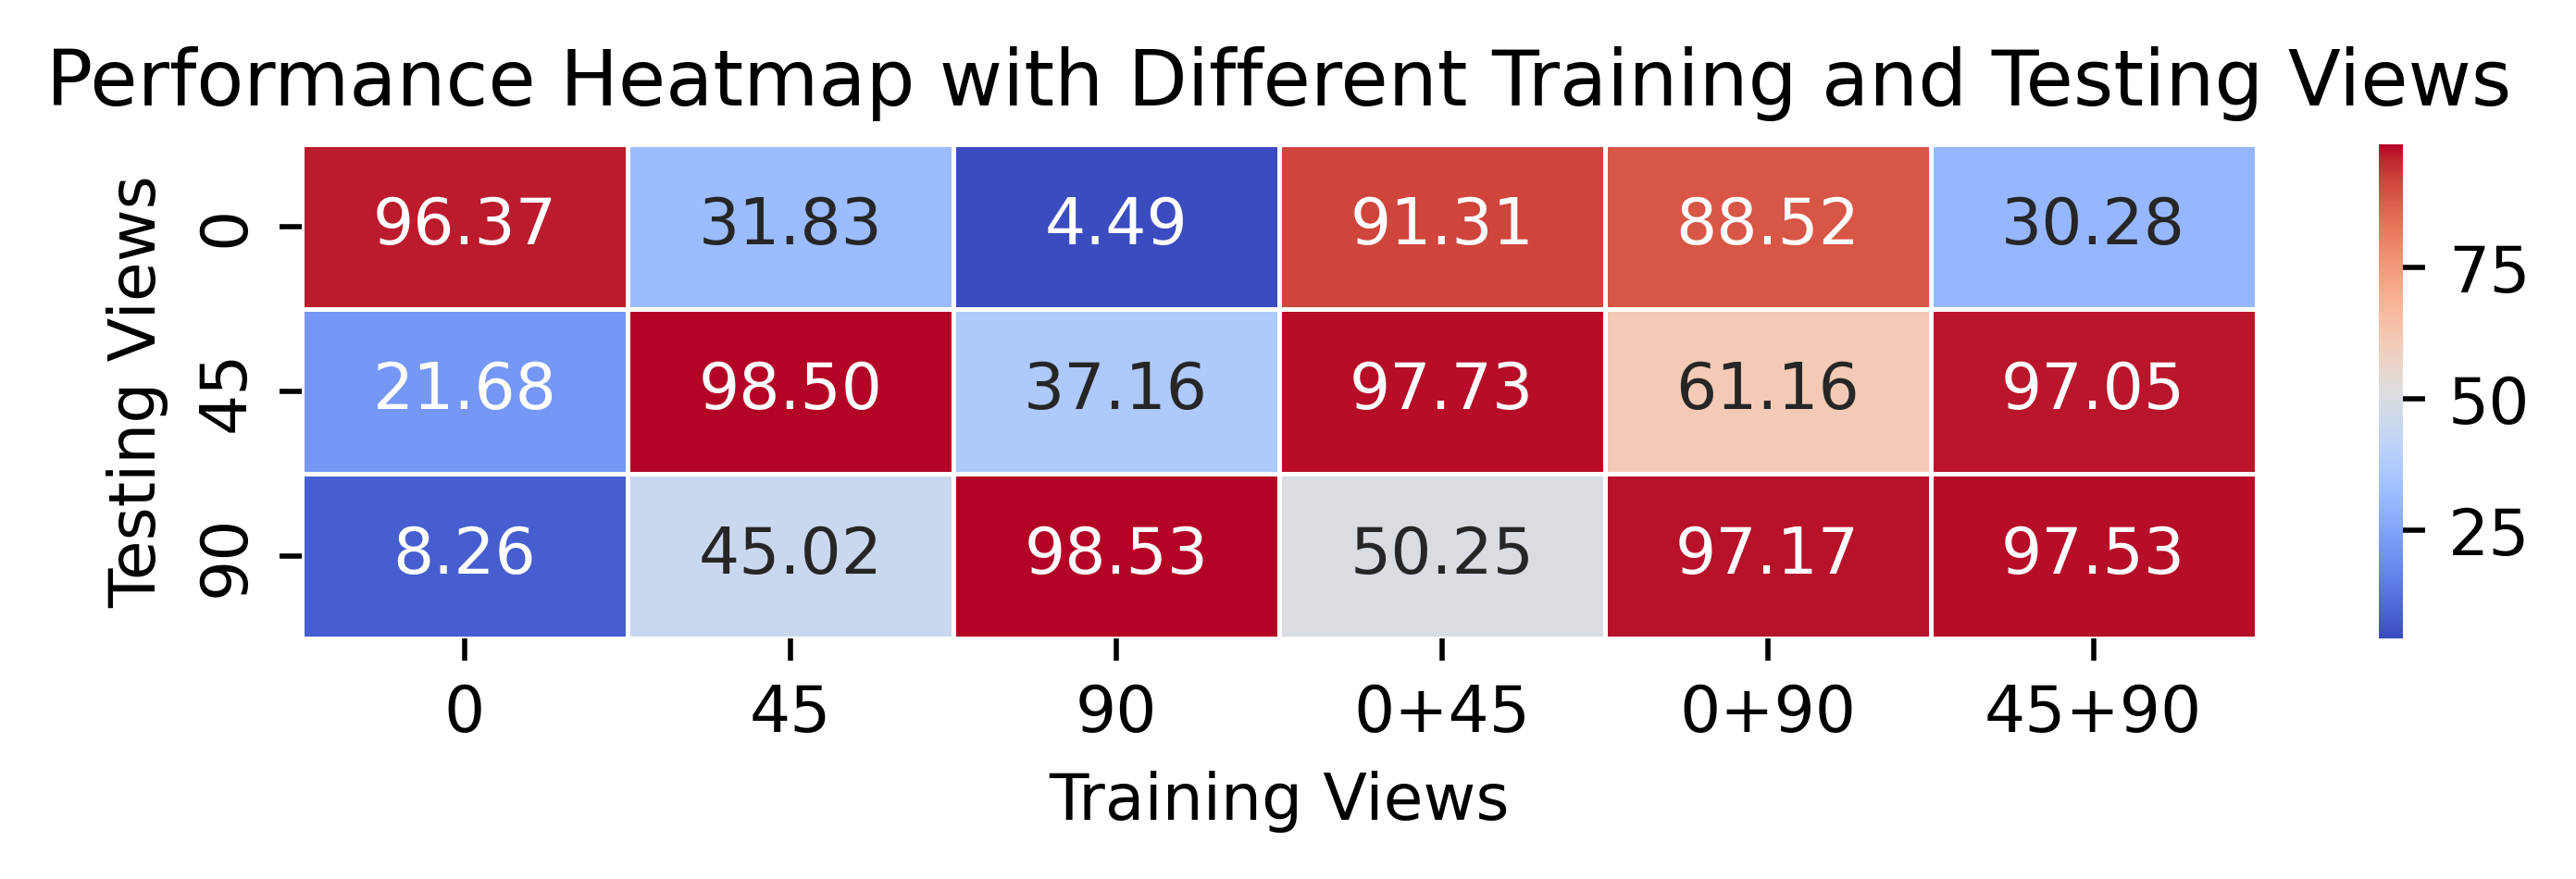

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Data for the heatmap
# Updated data with the user's provided values
data = {
    '0': [ 96.3694, 21.685, 8.255],
    '45': [31.8315, 98.4967, 45.020],
    '90': [4.4867, 37.1571, 98.5314],
    '0+45': [91.308, 97.731, 50.246],
    '0+90': [88.515, 61.164, 97.1697],
    '45+90': [30.2756, 97.0496, 97.5262]
}

# Convert the updated data into a DataFrame, with the test views as the index
df_updated = pd.DataFrame(data, index=['0', '45', '90'])

# Create the heatmap with the updated DataFrame
plt.figure(figsize=(6, 2))
heatmap = sns.heatmap(df_updated, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm')

# Customize the heatmap
plt.title('Performance Heatmap with Different Training and Testing Views')
plt.xlabel('Training Views')
plt.ylabel('Testing Views')

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything
plt.show()

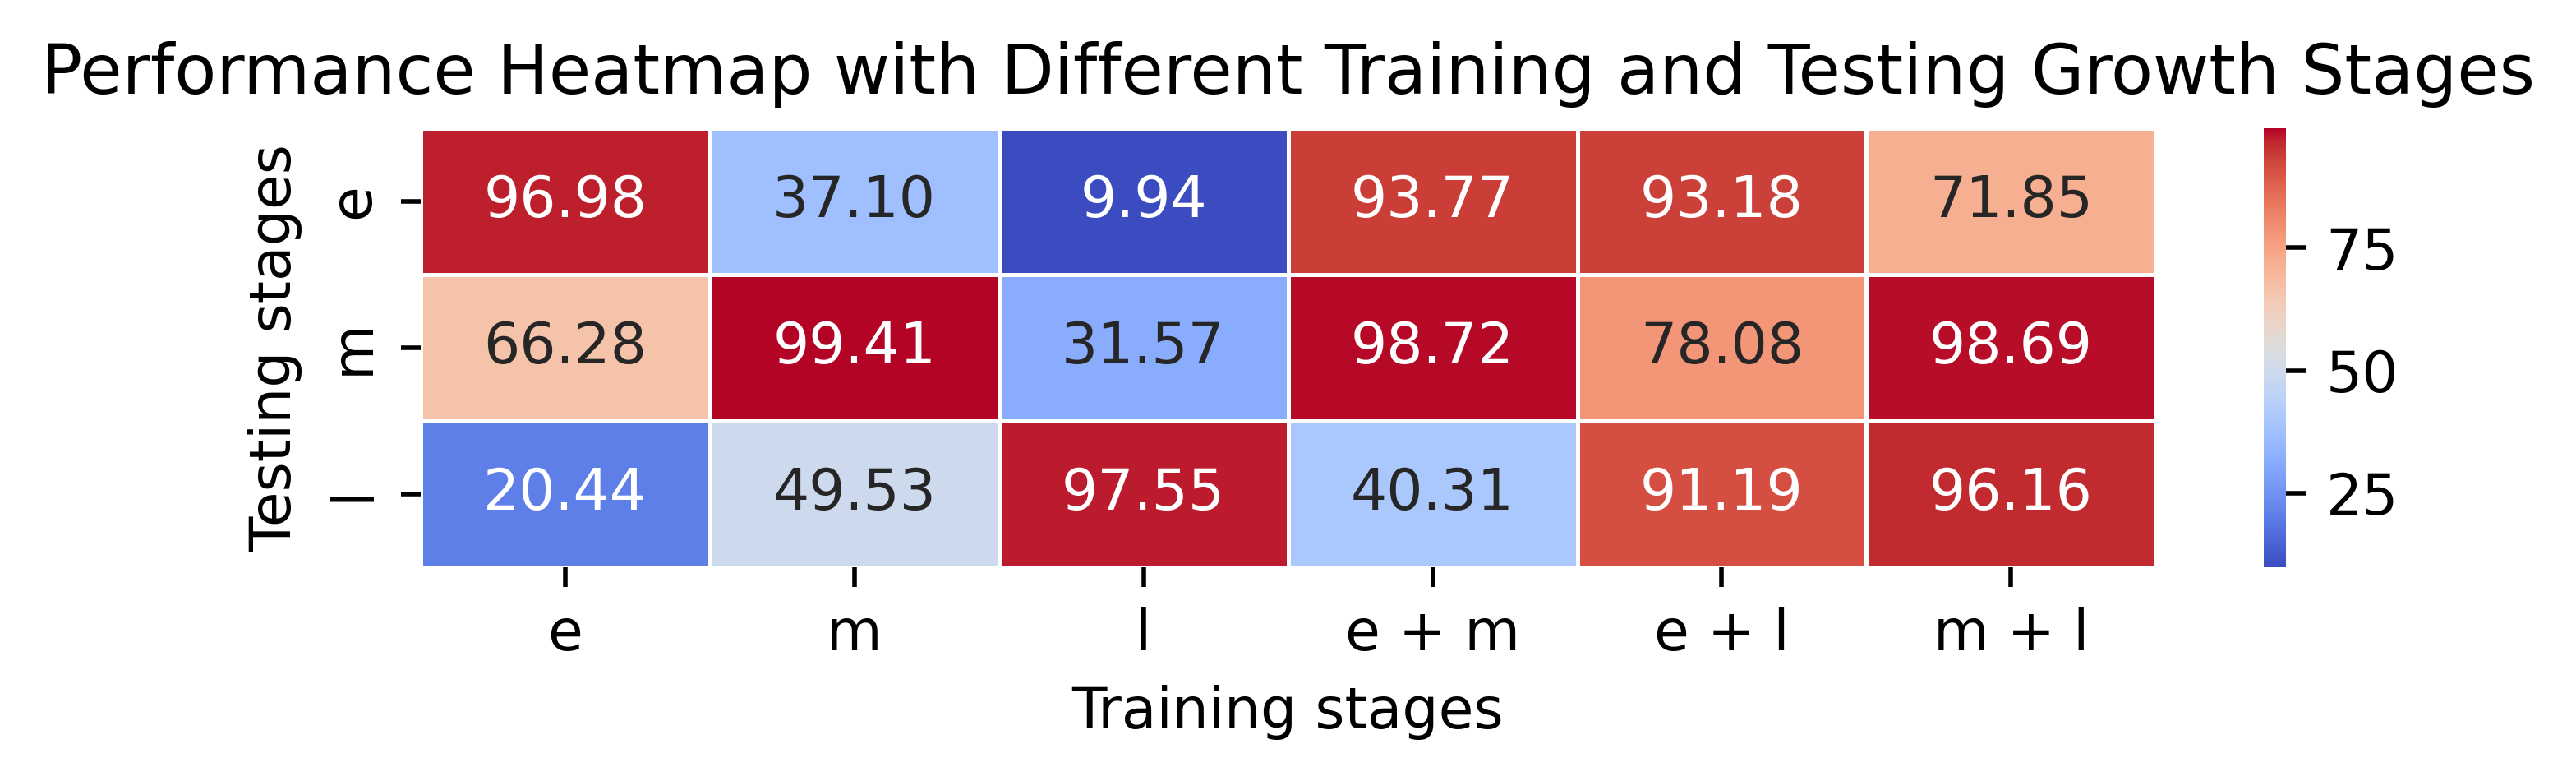

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
# Data for the heatmap
# Updated data with the user's provided values
data = {
    'e': [ 96.9800, 66.2829, 20.4439],
    'm': [37.1027, 99.4053, 49.5305],
    'l': [9.9429, 31.5675, 97.5458],
    'e + m': [93.7735, 98.7233, 40.3116],
    'e + l': [93.1801, 78.0839, 91.1865],
    'm + l': [71.8457, 98.6851, 96.1588]
}

# Convert the updated data into a DataFrame, with the test views as the index
df_updated = pd.DataFrame(data, index=['e', 'm', 'l'])

# Create the heatmap with the updated DataFrame
plt.figure(figsize=(6, 2))
heatmap = sns.heatmap(df_updated, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm')

# Customize the heatmap
plt.title('Performance Heatmap with Different Training and Testing Growth Stages')
plt.xlabel('Training stages')
plt.ylabel('Testing stages')

# Show the heatmap
plt.tight_layout()  # Adjust layout to fit everything
plt.show()